# DATA 620 Final Project

## 1. Setting up the Environment
### 1.1 Importing Libraries

In [90]:
import requests
import json
from datetime import datetime, timedelta
import time
from concurrent.futures import ThreadPoolExecutor
import os
import json
import pickle
import sys
import zipfile
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

### 1.2 Creating Functions

In [41]:
def zip_json_files_in_directory(directory_path):
    """
    Zips every .json file found in the specified directory into its own individual .zip archive.

    Args:
        directory_path (str): The absolute or relative path to the directory containing files to be zipped.

    Returns:
        int: The count of .json files successfully zipped.
    """
    if not os.path.isdir(directory_path):
        print(f"Error: Directory not found at path: {directory_path}")
        return 0

    zip_count = 0
    
    # Iterate over all entries in the directory
    for item_name in os.listdir(directory_path):
        item_path = os.path.join(directory_path, item_name)
        
        # Check if the item is a file
        if os.path.isfile(item_path):
            
            # --- NEW LOGIC: Check for .json extension ---
            base_name, extension = os.path.splitext(item_name)
            
            if extension.lower() == '.json':
                
                # Define the output zip filename
                # Example: 'app_730.json' becomes 'app_730.zip'
                zip_filename = os.path.join(directory_path, f"{base_name}.zip")
                
                # Check if the zip file already exists to potentially skip or overwrite
                if os.path.exists(zip_filename):
                    print(f"Skipping '{item_name}': Zip file already exists.")
                    continue
                    
                try:
                    # Create the individual zip archive
                    with zipfile.ZipFile(zip_filename, 'w', zipfile.ZIP_DEFLATED) as zf:
                        # Add the original file to the archive
                        zf.write(item_path, arcname=item_name)
                    os.remove(item_name)
                    print(f"✅ Zipped '{item_name}' to '{os.path.basename(zip_filename)}'")
                    zip_count += 1
                    
                except Exception as e:
                    print(f"❌ Failed to zip {item_name}: {e}")
            
    return zip_count

## 2. Setting up the data Pull

### 2.1 Creating a process to get all Reviews

We'll start this by creating functions that'll pull 100 reviews at a time and then creating a second function that'll allow us to pull these reviews in parallel.

In [34]:
def fetch_review_page(appid, cursor, start_date_timestamp, num_per_page, review_type, language):
    """
    Helper function to fetch a single page of Steam reviews for concurrent execution.
    Returns a tuple of (reviews, next_cursor, should_stop).
    """
    url = f"https://store.steampowered.com/appreviews/{appid}"
    params = {
        'json': 1,
        'filter': 'recent',
        'language': language,
        'review_type': review_type,
        'num_per_page': num_per_page,
        'cursor': cursor
    }

    try:
        response = requests.get(url, params=params, stream=True)
        response.raise_for_status()
        data = response.json()

        if data.get('success') != 1:
            return ([], None, True) # API call failed

        reviews = data.get('reviews', [])
        next_cursor = data.get('cursor')
        
        # --- NEW CODE START ---
        if reviews:
            # The API is filtered by 'recent', so the first review is usually the youngest.
            # We explicitly check the max just in case, but rely on the first element.
            youngest_timestamp = reviews[0].get('timestamp_created')
            if youngest_timestamp:
                youngest_date = datetime.fromtimestamp(youngest_timestamp).strftime('%Y-%m-%d %H:%M:%S')
                print(f"Latest review date found on this page: {youngest_date}")
        # --- NEW CODE END ---
        
        filtered_reviews = []
        should_stop = False

        for review in reviews:
            review_timestamp = review.get('timestamp_created')
            
            # Stop if we find a review older than the target date
            if review_timestamp and review_timestamp < start_date_timestamp:
                should_stop = True
                break
            
            filtered_reviews.append(review)
        
        return (filtered_reviews, next_cursor, should_stop)

    except (requests.exceptions.RequestException, json.JSONDecodeError) as e:
        print(f"An error occurred fetching cursor {cursor[:10]}: {e}")
        return ([], None, True)

In [35]:
def get_steam_reviews_from_2025(appid, num_per_page=100, review_type='all', language='english', max_workers=10, verbose=False):
    """
    Retrieves all user reviews for a Steam App ID posted from January 1st, 2025 onward,
    using concurrent requests.
    """
    all_reviews = []
    
    # Define a fixed start date timestamp (January 1st, 2025)
    start_date = datetime(2025, 1, 1)
    start_date_timestamp = start_date.timestamp()

    if verbose:
        print(f"Starting to fetch reviews for App ID {appid}. Looking for reviews newer than {start_date.strftime('%Y-%m-%d')}.")

    # Cursors to be fetched. Start with the initial cursor '*'.
    cursors_to_fetch = ['*']
    
    # Cursors that are currently being processed or scheduled.
    scheduled_cursors = set()
    
    # We will use a flag to signal when we've hit the chronological limit
    stop_fetching = False

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        
        futures = {} # Maps future objects to the cursor they are processing

        while cursors_to_fetch or futures:
            
            # 1. Schedule new jobs up to the max_workers limit
            while cursors_to_fetch and len(futures) < max_workers:
                cursor = cursors_to_fetch.pop(0)
                if cursor not in scheduled_cursors:
                    if verbose:
                        print(f"Scheduling page with cursor: {cursor[:10]}...")
                    future = executor.submit(
                        fetch_review_page, 
                        appid, cursor, start_date_timestamp, num_per_page, review_type, language
                    )
                    futures[future] = cursor
                    scheduled_cursors.add(cursor) # Mark as scheduled

            # If no jobs are scheduled and none are running, break
            if not futures:
                break
                
            # 2. Process results as they complete
            completed_futures = []
            for future in futures:
                if future.done():
                    try:
                        reviews, next_cursor, should_stop_page = future.result()
                        
                        if should_stop_page:
                            stop_fetching = True
                            
                        # Only append if we haven't hit the overall stop flag
                        if not stop_fetching:
                            all_reviews.extend(reviews)
                            
                        # If a next cursor is provided, and we're not stopping, add it to the queue
                        if next_cursor and not stop_fetching and next_cursor not in scheduled_cursors:
                            cursors_to_fetch.append(next_cursor)
                        
                        if verbose:
                            print(f"Page processed. Total reviews: {len(all_reviews)}. Next cursor: {next_cursor[:10] if next_cursor else 'None'}. Stop flag: {should_stop_page}")

                    except Exception as e:
                        print(f"Job failed for cursor {futures[future][:10]}: {e}")
                    
                    completed_futures.append(future)
            
            # Remove completed jobs from the dictionary
            for future in completed_futures:
                del futures[future]

            if stop_fetching:
                print("Chronological limit reached by a worker. Shutting down executor.")
                # Cancel pending jobs and stop scheduling new ones
                for future in futures:
                    future.cancel()
                break

            # Add a small delay to avoid busy-waiting, but be mindful of Steam's rate limit
            # Note: Parallel fetching already means higher rate, so the inherent delay 
            # while waiting for results helps, but we might need a more controlled throttling 
            # if this were a production system.
            time.sleep(0.001)

    return all_reviews

### 2.2 Creating a process to get all Steam App IDs

In [36]:
def get_all_steam_appids():
    """
    Fetches the list of all Steam applications and their App IDs using the
    GetAppList API endpoint.
    
    Returns:
        list: A list of dictionaries, where each dict has keys 'appid' and 'name'.
        Returns an empty list if the API call fails.
    """
    url = "https://api.steampowered.com/ISteamApps/GetAppList/v2/"
    
    print("🚀 Fetching complete list of all Steam applications. This may take a moment...")
    
    try:
        # Steam's GetAppList is a public, unauthenticated endpoint
        response = requests.get(url, timeout=30)
        response.raise_for_status() # Raise an exception for bad status codes
        
        data = response.json()
        
        # Navigate the JSON structure to the list of apps
        apps = data.get('applist', {}).get('apps', [])
        
        print(f"✅ Successfully retrieved {len(apps):,} applications.")
        return apps
        
    except requests.exceptions.RequestException as e:
        print(f"❌ API request failed: {e}")
        return []
    except json.JSONDecodeError:
        print("❌ Failed to decode JSON response.")
        return []

## 3. Retrieve Steam Reviews
### 3.1 Getting Steam App IDs

In order to get our data, we'll first need to get all the Steam App IDs. We can do this by pulling from the Steam API.

Once we have the App IDs, we can then use those to pull the reviews for each game.

In order to make sure we don't do this more than necessary, we'll save the App IDs to a file so we can reuse them later.

In [ ]:
# Read in the pickled list of Steam App IDs of the top 100 games
with open('top_100_steam_app_ids.pkl', 'rb') as f:
    top_100 = pickle.load(f)

# Fetch the complete list of Steam applications
app_id_list = get_all_steam_appids()

# Iterate over all Steam apps and fetch reviews for the top 100
for steam_app in app_id_list:
    
    # Skip apps not in the top 100
    if steam_app['appid'] not in top_100:
        continue
    else:
        
        # Prepare the save filepath
        save_filename = f"{steam_app['appid']}.json"
        save_filepath = f"data/{save_filename}"
        zip_filepath = f"data/{steam_app['appid']}.zip"

        print(zip_filepath)
        
        # Check if the file already exists
        if os.path.exists(save_filepath):
            print(f'Game "{steam_app['name']}" data already available. Skipping.')
        
        # Check if the zip version of the file exists
        elif os.path.exists(zip_filepath):
            print(f'Game "{steam_app['name']}" data zipped. Unzipping.')
            zipfile.ZipFile(zip_filepath, 'r').extractall(os.path.dirname(zip_filepath))

        # If not, fetch and save the reviews
        else:
            downloading_print_line = f"Fetching reviews for '{steam_app['name']}"
            
            print(f"\t\t{(len(downloading_print_line)+6)*'*'}\n\t\t*  {downloading_print_line}  *\n\t\t{(len(downloading_print_line)+6)*'*'}")
            reviews = get_steam_reviews_from_2025(
                appid=steam_app['appid'],
                num_per_page=100,
                review_type='all',
                language='english',
                verbose=False
            )

            # Save the reviews to a JSON file
            with open(save_filepath, 'w', encoding='utf-8') as f:
                json.dump(reviews, f, ensure_ascii=False, indent=4)

🚀 Fetching complete list of all Steam applications. This may take a moment...
✅ Successfully retrieved 276,371 applications.
data/440.zip
Game "Team Fortress 2" data zipped. Unzipping.
data/730.zip
Game "Counter-Strike 2" data zipped. Unzipping.
data/39210.zip
Game "FINAL FANTASY XIV Online" data zipped. Unzipping.
data/230410.zip
Game "Warframe" data zipped. Unzipping.
data/236390.zip
Game "War Thunder" data zipped. Unzipping.
data/238960.zip
Game "Path of Exile" data zipped. Unzipping.
data/252490.zip
Game "Rust" data zipped. Unzipping.
data/266410.zip
Game "iRacing" data zipped. Unzipping.
data/270880.zip
Game "American Truck Simulator" data zipped. Unzipping.
data/281990.zip
Game "Stellaris" data zipped. Unzipping.
data/284160.zip
Game "BeamNG.drive" data zipped. Unzipping.
data/306130.zip
Game "The Elder Scrolls Online" data zipped. Unzipping.
data/311210.zip
Game "Call of Duty: Black Ops III" data zipped. Unzipping.
data/322170.zip
Game "Geometry Dash" data zipped. Unzipping.
dat

### 3.2 Loading Reviews
With all of our data downloaded we can load it into memory for analysis.

In [48]:
all_reviews_data = []
search_path = 'data/*.json'

# Use glob to find all files matching the pattern
for filepath in glob.glob(search_path):
    # Extract the App ID from the filename for better logging
    filename = os.path.basename(filepath)
    app_id = filename.split('.')[0]
    
    try:
        with open(filepath, 'r', encoding='utf-8') as f:
            # Each file contains a list of review dictionaries, so we extend the master list
            reviews_list = json.load(f)
            
            # Optional: Add the app_id directly to each review dictionary for later network analysis
            for review in reviews_list:
                review['game_appid'] = app_id
            
            all_reviews_data.extend(reviews_list)
            
            print(f"Loaded {len(reviews_list):,} reviews from App ID {app_id}")
    except json.JSONDecodeError as e:
        print(f"❌ Error decoding JSON in {filename}: {e}")
    except Exception as e:
        print(f"❌ An unexpected error occurred while processing {filename}: {e}")

Loaded 0 reviews from App ID 238960
Loaded 0 reviews from App ID 236390
Loaded 79,171 reviews from App ID 3527290
Loaded 0 reviews from App ID 2074920
Loaded 144 reviews from App ID 3364070
Loaded 563 reviews from App ID 2879840
Loaded 95,267 reviews from App ID 3241660
Loaded 300 reviews from App ID 2429640
Loaded 39,295 reviews from App ID 1086940
Loaded 3,199 reviews from App ID 1466860
Loaded 4,842 reviews from App ID 3167020
Loaded 2,666 reviews from App ID 1449110
Loaded 12,116 reviews from App ID 3159330
Loaded 0 reviews from App ID 3224770
Loaded 105,269 reviews from App ID 1030300
Loaded 700 reviews from App ID 266410
Loaded 41,462 reviews from App ID 1808500
Loaded 10,600 reviews from App ID 2399830
Loaded 45,577 reviews from App ID 1771300
Loaded 5,099 reviews from App ID 518790
Loaded 0 reviews from App ID 438100
Loaded 8,900 reviews from App ID 270880
Loaded 15,899 reviews from App ID 1623730
Loaded 33,394 reviews from App ID 322170
Loaded 73,806 reviews from App ID 224634

Reviewing some of the data to ensure it loaded correctly.

In [55]:
all_reviews_data[:1]

[{'recommendationid': '207973826',
  'author': {'steamid': '76561198157288722',
   'num_games_owned': 0,
   'num_reviews': 13,
   'playtime_forever': 3321,
   'playtime_last_two_weeks': 0,
   'playtime_at_review': 3321,
   'last_played': 1757301477},
  'language': 'english',
  'review': 'i love yell at my friends simulator',
  'timestamp_created': 1761843667,
  'timestamp_updated': 1761843667,
  'voted_up': True,
  'votes_up': 0,
  'votes_funny': 0,
  'weighted_vote_score': 0.5,
  'comment_count': 0,
  'steam_purchase': True,
  'received_for_free': False,
  'written_during_early_access': False,
  'primarily_steam_deck': False,
  'game_appid': '3527290'}]

## 4. Sentiment Analysis
With all of our reviews loaded we can now perform sentiment analysis on the data to determine how users feel about different games.

### 4.1 Inspecting Reviews
Starting off this analysis we'll see which games have the most positive and negative reviews.

In [86]:
# Creating an empty dictionary to store reviews
review_ratios = {}

# Analyzing review sentiments
for review in all_reviews_data:
    t_app_id = review['game_appid']
    
    # Initialize the app ID entry if it doesn't exist
    if t_app_id not in review_ratios.keys():
        review_ratios[t_app_id] = {
            'rated_up': 0,
            'rated_down': 0,
            'percent_positive' : 0.0
        }

        for e in app_id_list:
            if str(e['appid']) == t_app_id:
                review_ratios[t_app_id]['name'] = e['name']
                break

    # Increment the appropriate counter based on the review sentiment
    if review['voted_up']:
        review_ratios[t_app_id]['rated_up'] += 1
    else:
        review_ratios[t_app_id]['rated_down'] += 1

    # Calculating positive review ratios
    review_ratios[t_app_id]['percent_positive'] = (
        review_ratios[t_app_id]['rated_up'] /
        (review_ratios[t_app_id]['rated_up'] + review_ratios[t_app_id]['rated_down'])
    ) * 100.0

/tmp/ipykernel_345752/1761837763.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345752/1761837763.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345752/1761837763.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345752/1761837763.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipykernel_345752/1761837763.py:32: UserWarn

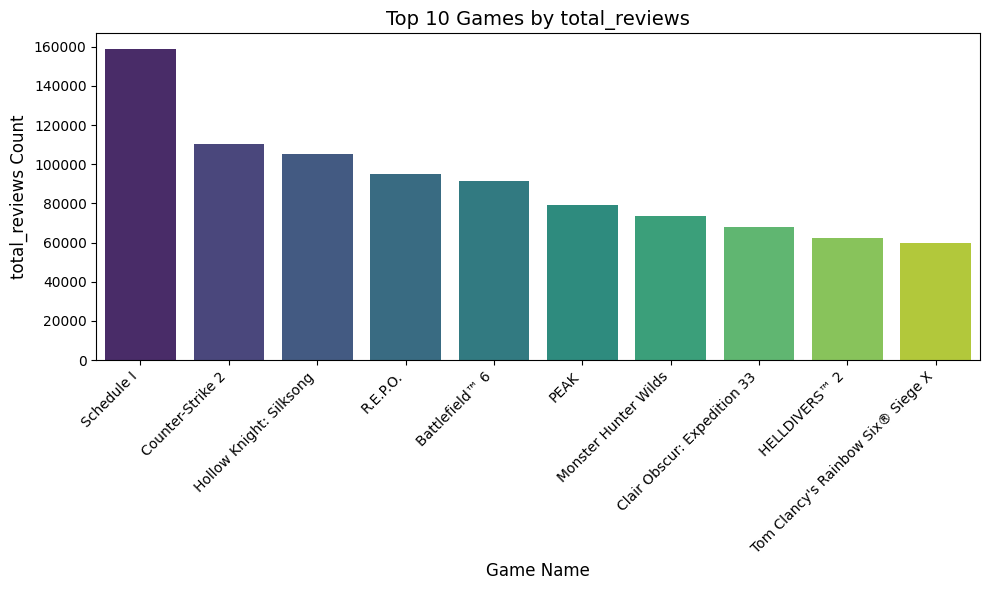

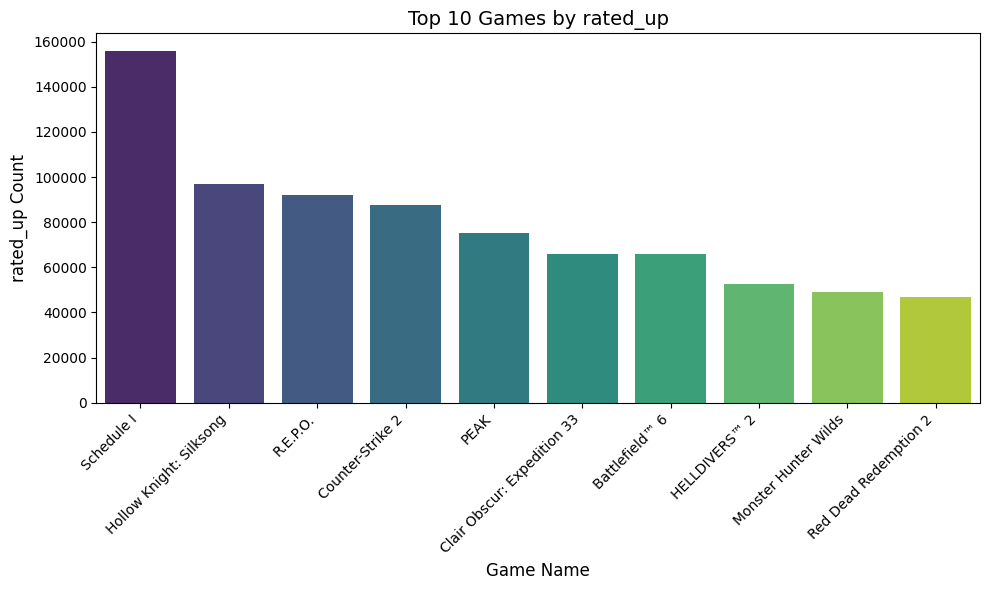

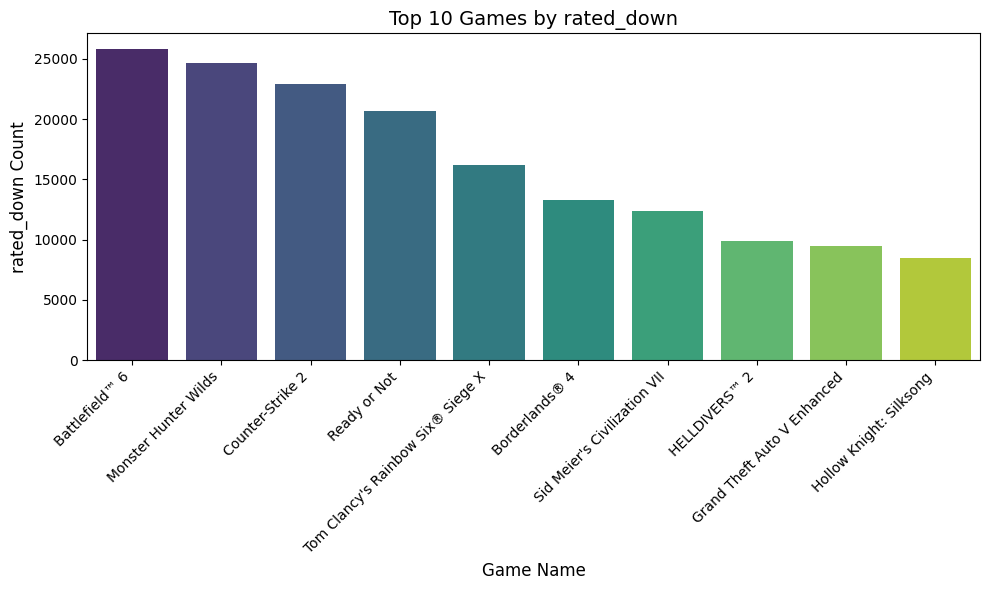

/home/richie/work/cuny-msds/data620-web-analytics/assignments/DATA620/data620env/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127867 (\N{CLINKING BEER MUGS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


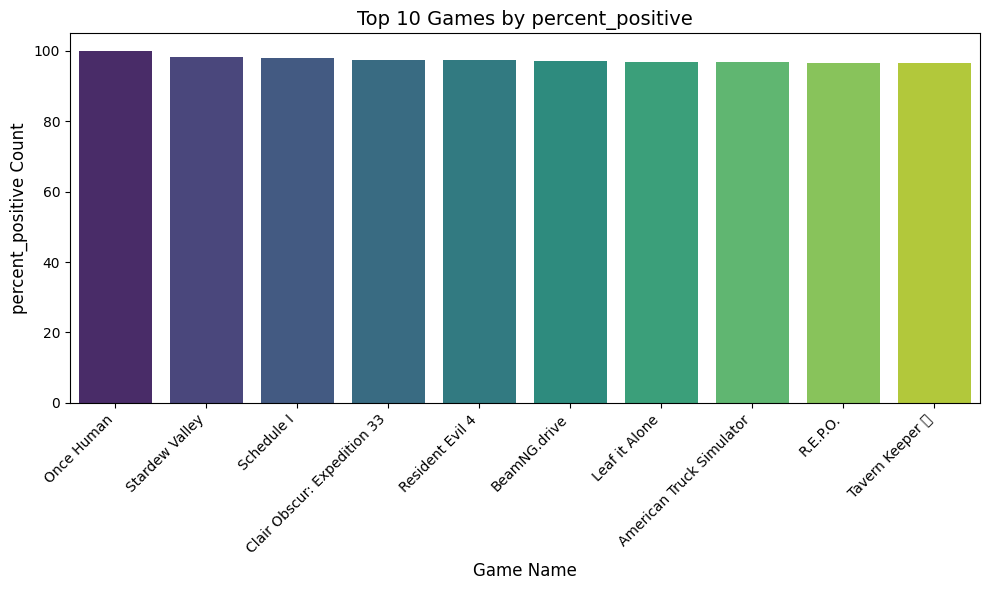

In [ ]:
# Creating a DataFrame for visualization
viz_1_df = pd.DataFrame.from_dict(review_ratios, orient='index')
viz_1_df.index.name = 'AppID'

viz_1_df['total_reviews'] = viz_1_df['rated_up'] + viz_1_df['rated_down']

metrics_to_plot = [
    'total_reviews',
    'rated_up',
    'rated_down',
    'percent_positive'
]

for metric in metrics_to_plot:
    t_viz_df = viz_1_df.copy().sort_values(by=metric, ascending=False).head(10).reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=t_viz_df,
        x='name', 
        y=metric,
        palette="viridis",
        order=t_viz_df['name'] 
    )

    plt.title(f'Top 10 Games by {metric}', fontsize=14)
    plt.xlabel('Game Name', fontsize=12)
    plt.ylabel(f'{metric} Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

We can see that there are a lot of differences between games in terms of user sentiment. Some games have a very high percentage of positive reviews, while others have a much lower percentage.

It's difficult to see the differences in `percent_positive` values in a bar chart, so let's try a histogram to get a better sense of the distribution.

array([[<Axes: title={'center': 'percent_positive'}>]], dtype=object)

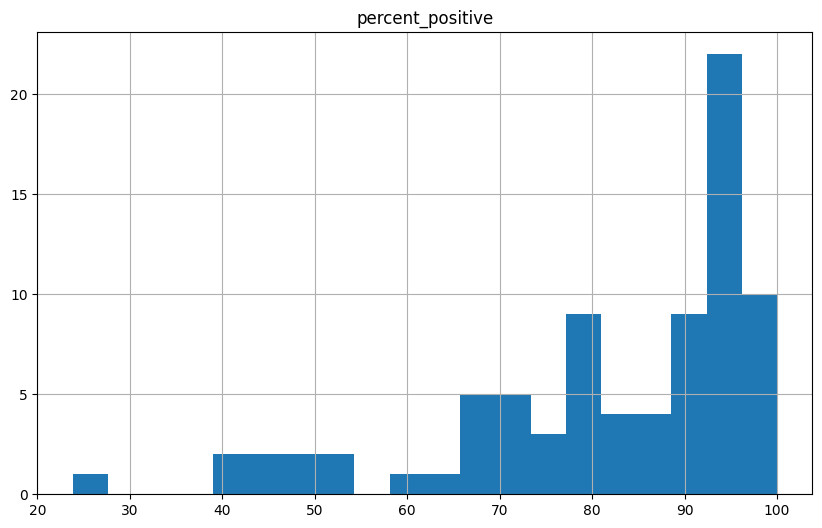

In [102]:
viz_1_df.hist(
    column='percent_positive',
    bins=20,
    figsize=(10,6)
)

With a histogram we can see that the majority of games have a high percentage of positive reviews, with a smaller number of games having a lower percentage of positive reviews. This makes sense as it's the top 100 and the most popular games on Steam are likely to be well-liked by users.

### 4.2 Text Analysis

For this section we'll go through the text of the reviews to see what words are most commonly used in positive and negative reviews. We'll attempt to find any patterns in the words used in reviews to see if there are any common themes among positive and negative reviews.

## 5. Network Analysis for Reviewers

### 5.1 Network Construction

### 5.2 Core Network Analysis